<a href="https://colab.research.google.com/github/davepruitt/petrarca_il_canzoniere_ml/blob/main/petrarca_il_canzoniere.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Imports

import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional

In [2]:
#We need to somehow access the text. For now, let's just have the user upload it.
from google.colab import files
uploaded = files.upload()

file_name = ""
for fn in uploaded.keys():
    file_name = fn
    print("User uploaded file {name} with {length} bytes".format(name=fn, length=len(uploaded[fn])))


Saving petrarca_il_canzoniere.txt to petrarca_il_canzoniere.txt
User uploaded file petrarca_il_canzoniere.txt with 294981 bytes


In [3]:
#Let's get the full text and decode it using the "latin1" encoding.
full_text = uploaded[file_name].decode("latin1")

#Convert the full text to lowercase
full_text = full_text.lower()

#Print the first 100 characters just as a sanity check to see if it looks right.
print(full_text[0:100])

il canzoniere (rerum vulgarium fragmenta)
di francesco petrarca



1

voi ch'ascoltate in rime spars


In [4]:
#Now let's split the text into a list of lines
corpus = full_text.splitlines()

print(f"Total lines: {len(corpus)}")
print("First 10 lines:")

#Print the first several lines as a sanity check
for i in range(0, 10):
    print(corpus[i])

Total lines: 10480
First 10 lines:
il canzoniere (rerum vulgarium fragmenta)
di francesco petrarca



1

voi ch'ascoltate in rime sparse il suono
di quei sospiri ond'io nudriva 'l core
in sul mio primo giovenile errore


In [5]:
#Now let's get rid of all lines that are only white-space, or empty lines, or lines that contain a number

def is_line_ok(current_line):
    stripped_line = current_line.strip()
    return (len(stripped_line) > 0) and (not stripped_line.isnumeric())

corpus = [x for x in corpus if is_line_ok(x)]

print(f"Total lines: {len(corpus)}")
print("First 10 lines:")

#Print the first several lines as a sanity check
for i in range(0, 10):
    print(corpus[i])

Total lines: 7787
First 10 lines:
il canzoniere (rerum vulgarium fragmenta)
di francesco petrarca
voi ch'ascoltate in rime sparse il suono
di quei sospiri ond'io nudriva 'l core
in sul mio primo giovenile errore
quand'era in parte altr'uom da quel ch'i' sono,
del vario stile in ch'io piango et ragiono
fra le vane speranze e 'l van dolore,
ove sia chi per prova intenda amore,
spero trovar pietà, nonché perdono.


In [6]:
#Create a tokenizer for the text

tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

print(f"Total words: {total_words}")

Total words: 7957


In [7]:
def n_gram_seqs(corpus, tokenizer):
    '''
    Generates a list of n-gram sequences
    '''

    input_sequences = []
    for line in corpus:
        token_list = tokenizer.texts_to_sequences([line])[0]

        for i in range(1, len(token_list)):
            n_gram_sequence = token_list[:i+1]
            input_sequences.append(n_gram_sequence)

    return input_sequences

In [8]:
#Let's test the n_grams_seqs function
first_example_sequence = n_gram_seqs([corpus[0]], tokenizer)

print("n_gram sequences for first example look like this:\n")
first_example_sequence

n_gram sequences for first example look like this:



[[9, 3512],
 [9, 3512, 3513],
 [9, 3512, 3513, 3514],
 [9, 3512, 3513, 3514, 3515]]

In [9]:
#Apply the n_gram_seqs transformation to the whole corpus
input_sequences = n_gram_seqs(corpus, tokenizer)

#Save the max length
max_sequence_len = max([len(x) for x in input_sequences])
print(f"n_grams of input_sequences have length: {len(input_sequences)}")
print(f"maximum length of sequences is: {max_sequence_len}")

n_grams of input_sequences have length: 45963
maximum length of sequences is: 12


In [10]:
#Pad the whole corpus
input_sequences = pad_sequences(input_sequences, maxlen=max_sequence_len, padding="pre")

print(f"Padded corpus has shape: {input_sequences.shape}")

Padded corpus has shape: (45963, 12)


In [11]:
def features_and_labels(input_sequences, total_words):
    '''
    Generates features and labels from n-grams
    '''

    features = input_sequences[:, :-1]
    labels = input_sequences[:, -1]
    one_hot_labels = to_categorical(labels, num_classes=total_words)

    return features, one_hot_labels

In [12]:
#Test the features_and_labels function:
features, labels = features_and_labels(input_sequences, total_words)

print(f"features have shape: {features.shape}")
print(f"labels have shape: {labels.shape}")

features have shape: (45963, 11)
labels have shape: (45963, 7957)


In [15]:
def create_model (total_words, max_sequence_len):
    '''
    Creates a text generator model
    '''

    model = Sequential()
    model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
    model.add(Bidirectional(LSTM(150)))
    model.add(Dense(total_words, activation="softmax"))

    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

    return model


In [16]:
# Get the untrained model
model = create_model(total_words, max_sequence_len)

# Train the model
history = model.fit(features, labels, epochs=50, verbose=1)

Epoch 1/50
1437/1437 [==============================] - 29s 17ms/step - loss: 7.3172 - accuracy: 0.0440
Epoch 2/50
1437/1437 [==============================] - 16s 11ms/step - loss: 6.6371 - accuracy: 0.0711
Epoch 3/50
1437/1437 [==============================] - 17s 12ms/step - loss: 6.1724 - accuracy: 0.0913
Epoch 4/50
1437/1437 [==============================] - 18s 12ms/step - loss: 5.7087 - accuracy: 0.1059
Epoch 5/50
1437/1437 [==============================] - 21s 15ms/step - loss: 5.2116 - accuracy: 0.1244
Epoch 6/50
1437/1437 [==============================] - 24s 17ms/step - loss: 4.7002 - accuracy: 0.1551
Epoch 7/50
1437/1437 [==============================] - 19s 13ms/step - loss: 4.2165 - accuracy: 0.2040
Epoch 8/50
1437/1437 [==============================] - 20s 14ms/step - loss: 3.7724 - accuracy: 0.2668
Epoch 9/50
1437/1437 [==============================] - 17s 12ms/step - loss: 3.3736 - accuracy: 0.3300
Epoch 10/50
1437/1437 [==============================] - 18s 12m

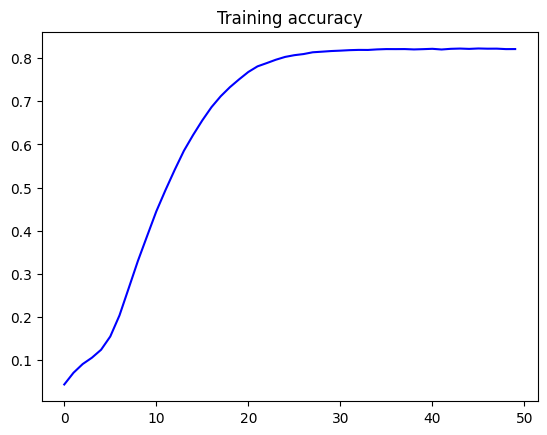

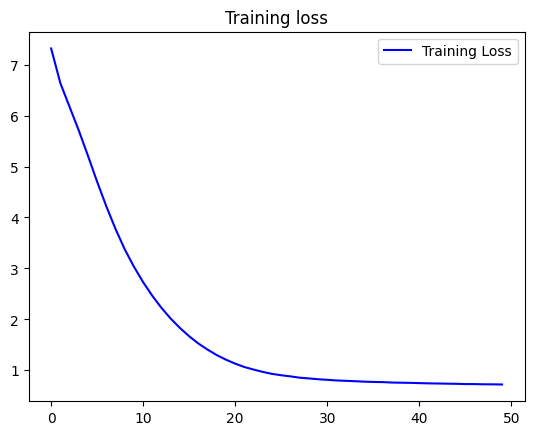

In [17]:
# Let's take a look at the training curves of our model

acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [18]:
#Now let's take a look at how our model does "in action"
seed_text = "Aiutami, Obi Wan Kenobi, tu sei la mia unica speranza"
next_words = 100

for _ in range(next_words):
    # Convert the text into sequences
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    # Pad the sequences
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    # Get the probabilities of predicting a word
    predicted = model.predict(token_list, verbose=0)
    # Choose the next word based on the maximum probability
    predicted = np.argmax(predicted, axis=-1).item()
    # Get the actual word from the word index
    output_word = tokenizer.index_word[predicted]
    # Append to the current text
    seed_text += " " + output_word

print(seed_text)

Aiutami, Obi Wan Kenobi, tu sei la mia unica speranza o i miei cercai laura scoppia sperava chiamata parl'io don ceco di' antichi l'uscio mostrando ond'ogni ben terra perché 'l pianger m'à com'oro intero oltra tutto perdei provede l'andar et merito human non human ond'ogni sormonta honora velo negar sentisse canzon durezze scriva mancata mancata mancata contendi maggior' la diversa et faticoso s'i' fronde fronde vil obiecto ricettando rive preghiera d'acqua humano percosso su l'onde parla mani et merito merito faticoso il pregio il piú amaro pena cresce solo ridir mancata ponente guerra volontaria guerra costor agli occhi col viso cantando pensier' congiurato piove ov'ogni vene over ch'oggi il over
